# GeoML with EuroSAT Notebook
In this notebook, we download and visualize EuroSAT data from both the spatial and non-spatial splits. We then train two ResNet50 image encoders on each dataset, one with randomly initialized weights and one with pre-initialized weights from SSL4EO-S12. We then evaluate each on the test and train data, and then customize the training.  

## 1. Download and Visualize EuroSat Data

In this section, we use the torchgeo dataset/datamodules to download the EuroSat dataset (spatial and nonspatial split versions). We then plot a random sample of 6 images (with labels) from the training set and the test set for each dataset version. We also calculate the number of samples in each split for each version (spatial and nonspatial).

In [56]:
import os
from torch.utils.data import DataLoader
from torchgeo.datasets import EuroSAT, EuroSATSpatial, EuroSAT100

### EuroSAT 100

In [57]:
eurosat100_root = os.path.join("data", "eurosat100")
eurosat100_dataset_train = EuroSAT100(eurosat100_root, split="train", download=True)
eurosat100_dataset_test = EuroSAT100(eurosat100_root, split="test", download=True)

print(f'Dataset Classes: {eurosat100_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat100_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat100_dataset_test)}')

Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 60
Number of images in test dataset: 20


### EuroSAT

In [58]:
eurosat_root = os.path.join("data", "eurosat")
eurosat_dataset_train = EuroSAT(eurosat_root, split="train", download=True)
eurosat_dataset_test = EuroSAT(eurosat_root, split="test", download=True)

print(f'Dataset Classes: {eurosat_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat_dataset_test)}')

Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 16200
Number of images in test dataset: 5400


### EuroSAT Spatial

In [59]:
eurosat_spatial_root = os.path.join("data", "eurosatSpatial")
eurosat_spatial_dataset_train = EuroSATSpatial(eurosat_spatial_root, split="train", download=True)
eurosat_spatial_dataset_test = EuroSATSpatial(eurosat_spatial_root, split="test", download=True)

print(f'Dataset Classes: {eurosat_spatial_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat_spatial_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat_spatial_dataset_test)}')

Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 16200
Number of images in test dataset: 5400


### # of Images in Each Dataset Split
Split    | EuroSAT100   | EuroSAT   | EuroSAT Spatial   |
---------|-----------   |---------  |---------          |
Train    |  60          |   16200   |   16200           |
Validate |  20          |   5400    |   5400            |
Test     |  20          |   5400    |   5400            |

### Visualize Images and Labels from Each Dataset

In [60]:
import random
import matplotlib.pyplot as plt
# set seed for reproducibility
random.seed(44)

In [61]:
eurosat_datasets = {
    "eurosat_train": eurosat_dataset_train,
    "eurosat_test": eurosat_dataset_test,
    "eurosat_spatial_train": eurosat_spatial_dataset_train,
    "eurosat_spatial_test": eurosat_spatial_dataset_test
}
figures_base_path = os.path.join("figures", "eurosat100")


# sample 6 random images, plot, and export the figures
for name, dataset in eurosat_datasets.items():
    n = 0
    for i in random.sample(range(len(dataset)), 6):
        fig = dataset.plot(
            sample=dataset.__getitem__(i),
            show_titles=True
        )
        # export fig to png
        path = os.path.join("figures", "eurosat", f"{name}_{n}.png")
        fig.savefig(path)
        plt.close(fig)
        n += 1

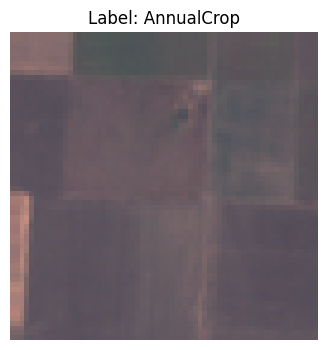

In [62]:
# visualize just one image
fig = eurosat_dataset_train.plot(
    sample=eurosat_dataset_train.__getitem__(0),
    show_titles=True
)

## 2. Train & Evaluate a Model on the EuroSAT Data 

In this section, we train two ResNet 50 models on the nonspatial EuroSat dataset: one with randomly initialized weights, and one with pre-initialized weights from the SSL4EO-S12 project (use the pretrained weights available in torchgeo). We report the performance of these models on the train and test sets in a table. In addition to the table, we report (i) how we implemented the training and evaluation procedure, what hyperparameters we use to train the model, and how we choose those hyperparameters (e.g. if we perform a cross-validation search for hyperparameters, we explain how you conducted that search), (ii) what pretrained weights we choose to use, and a short description of the process used to generate those weights, (iii) a short paragraph describing the results in your table in words.

The flow of this section is as follows:
1. Import an empty ResNet50 model
1. Define a data sampler and loader
1. Train the model
1. Evaluate the model
1. Conduct a hyperparameter search with cross validation
1. Report results

In [110]:
import torch # for model training
from torch import nn # for neural network layers
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms # to resize input images
from torchvision.models import resnet50 # import resnet50 model from torchvision

#### Define the Model

In [111]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [112]:
# import torchvision
model = resnet50().to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [113]:
# define training parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [119]:
# train loop
# from the pytorch tutorial
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, sample in enumerate(dataloader):
        X, y = sample['image'], sample['label']
        # Ensure the data is in the correct format
        if isinstance(X, torch.Tensor) and X.ndim == 4:
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 10 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        else:
            print(f"Unexpected data format: {type(X)}, shape: {X.shape if isinstance(X, torch.Tensor) else 'N/A'}")

In [120]:
# test loop
# from the pytorch tutorial
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for sample in dataloader:
            X, y = sample['image'], sample['label']
            # Ensure the data is in the correct format
            if isinstance(X, torch.Tensor) and X.ndim == 4:
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            else:
                print(f"Unexpected data format: {type(X)}, shape: {X.shape if isinstance(X, torch.Tensor) else 'N/A'}")
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


#### Define the Dataloaders

In [129]:
batch_size = 8

# Custom transform function to handle the dictionary structure of torchgeo dataset
class CustomTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample
    
# Define transformations for the dataset to get it from 64x64 to 224x224
transform = transforms.Resize((224, 224))  # Resizes the images to 224x224

custom_transform = CustomTransform(transform)

# reload data with the new transform
eurosat_root = os.path.join("data", "eurosat")
eurosat_dataset_train = EuroSAT(eurosat_root, split="train", download=True, transforms=custom_transform)
eurosat_dataset_test = EuroSAT(eurosat_root, split="test", download=True, transforms=custom_transform)

# define a sampler for the EuroSAT dataset
# it's a non-spatial dataset, so we can use a regular sampler from pytorch
sampler_train = RandomSampler(eurosat_dataset_train, replacement=False) # start with a small batch
dataloader_train = DataLoader(eurosat_dataset_train, batch_size=batch_size, sampler=sampler_train)

sampler_test = RandomSampler(eurosat_dataset_test, replacement=False) # start with a small batch
dataloader_test = DataLoader(eurosat_dataset_test, batch_size=batch_size, sampler=sampler_test)

In [125]:
# modify the ResNet model to have 10 output classes
model.fc = nn.Linear(2048, 10).to(device)

# modify the model to expect 13 channels instead of 3
model.conv1 = nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)

#### Train & Test the Model

In [ ]:
# run train / test loop
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader_train, model, loss_fn, optimizer)
    test(dataloader_test, model, loss_fn)
print("Done!")

## 3. Train & Evaluate a Model on the EuroSAT Spatial Data

## 4. Customize the Model